Bienvenidos al laboratorio 1 de Aprendiza de Maquina con la profesora Maria Villamil
Integrantes: Juan Eduardo Briceño 202320095 - Santiago Alberto Quiroz 202216453

Empecemos con la importacion de todos las librerias que se usaran a lo largo del laboratorio

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


Ahora vamos a definir las rutas para los archivos que vamos a usar en este caso queremos el path de los datos de entrenamiento, los datos de prueba y los datos del diccionario

In [44]:
train = "./data/Datos Lab 1.csv"
test = "./data/Datos Test Lab 1.csv"
dicc = "./data/DiccPacientes.xlsx"

asdasdasd

In [45]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test, sep=";")
df_dicc = pd.read_excel(dicc)

📊 Columnas numéricas encontradas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
🏷️  Columnas categóricas encontradas: ['Sex', 'Blood Pressure (mmHg)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']
✅ Filas en df_train original: 1639
✅ Filas después de quitar NaN en target: 1610
✅ Columnas ANTES del encoding: 24
✅ Columnas DESPUÉS del encoding: 1156
   Se crearon 1132 columnas nuevas
✅ X (features): (1610, 1152)
✅ y (target): (1610,)
✅ Valores NaN eliminados mediante imputación con la mediana
✅ Creada feature: BMI_Age
✅ Creadas features: BP_diff, BP_ratio
✅ Creada feature: Chol_HDL_ratio
✅ Features totales ahora: 1156

📊 Top 10 features más correlacionadas:
Blood Pressure (mmHg)_102/90     0.224078
Blood Pressure (mmHg)_1

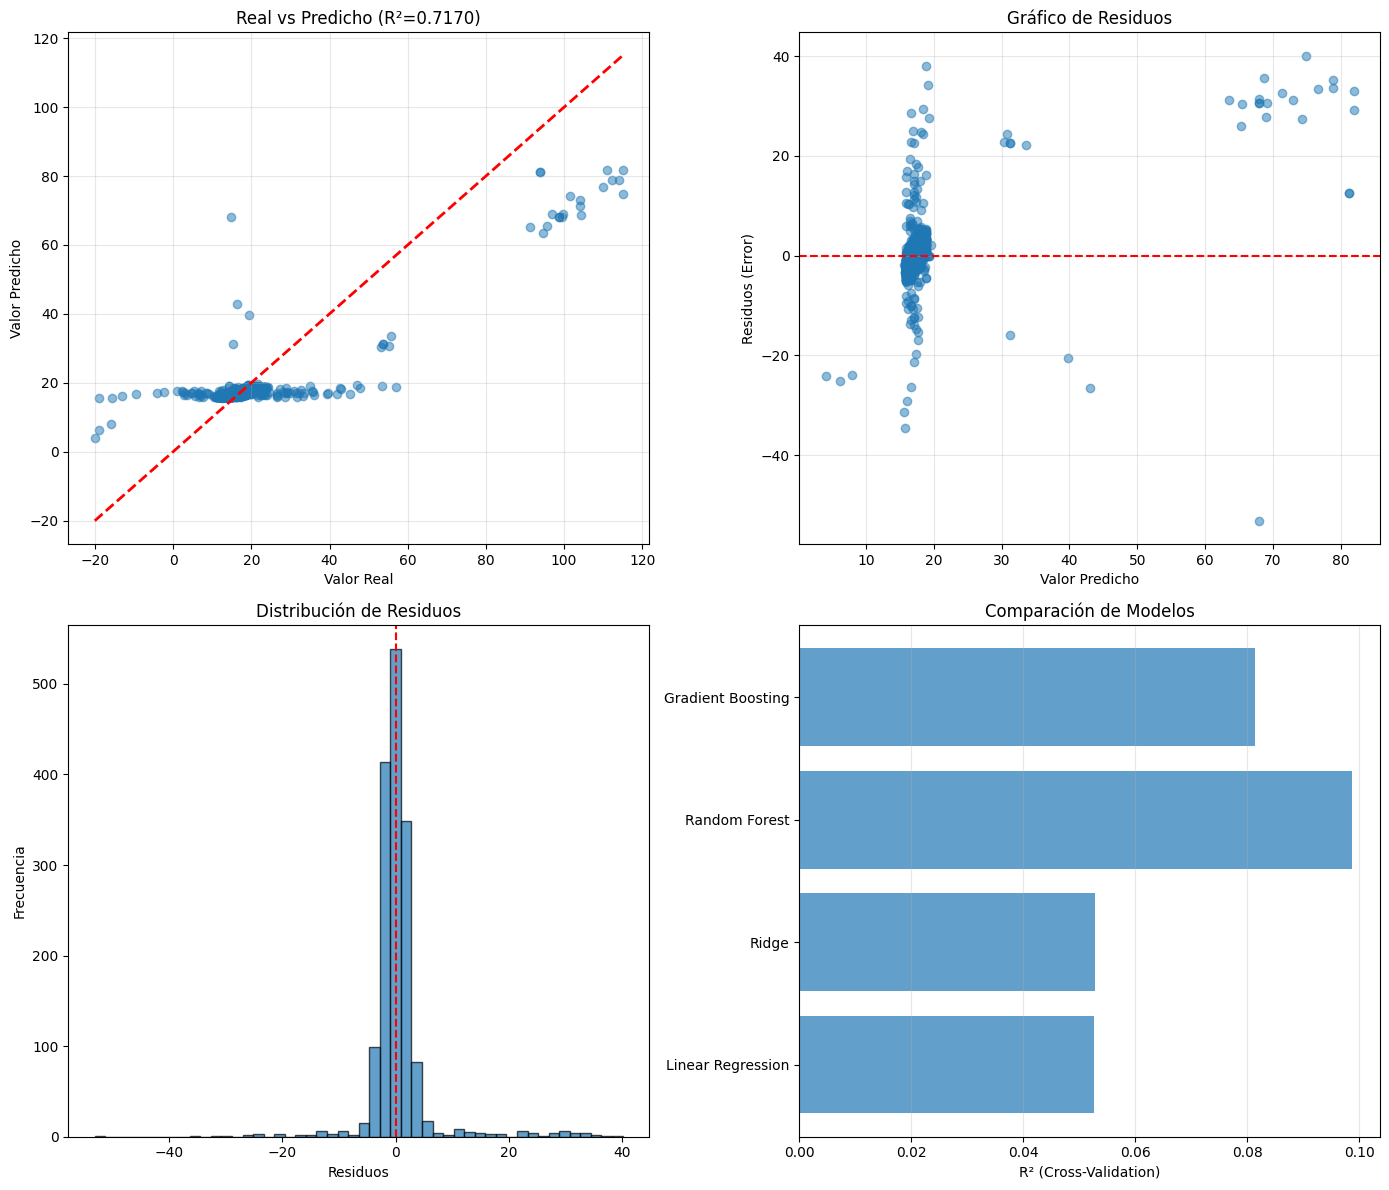


✅ Código completado exitosamente!


In [46]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ========================================
# PASO 1: DEFINIR QUÉ COLUMNAS USAR
# ========================================

# La columna que queremos PREDECIR
target = "CVD Risk Score"

# Columnas que NO queremos usar como features (porque son IDs o el target mismo)
cols_to_remove = ["CVD Risk Score", "CVD Risk Level", "Patient ID", "Date of Service"]

# Encontrar columnas NUMÉRICAS (números: edad, peso, presión, etc.)
numeric_cols = [
    c for c in df_train.columns  # Para cada columna en df_train
    if c not in cols_to_remove  # Que NO esté en cols_to_remove
    and pd.api.types.is_numeric_dtype(df_train[c])  # Y que sea numérica
]

# Encontrar columnas CATEGÓRICAS (texto: género, sí/no, etc.)
categorical_cols = [
    c for c in df_train.columns  # Para cada columna en df_train
    if c not in cols_to_remove  # Que NO esté en cols_to_remove
    and not pd.api.types.is_numeric_dtype(df_train[c])  # Y que NO sea numérica
]

print("📊 Columnas numéricas encontradas:", numeric_cols)
print("🏷️  Columnas categóricas encontradas:", categorical_cols)

# ========================================
# PASO 2: LIMPIAR DATOS DE ENTRENAMIENTO
# ========================================

# Eliminar filas donde el TARGET esté vacío (no podemos entrenar sin saber la respuesta)
df_clean = df_train.dropna(subset=[target]).copy()

print(f"✅ Filas en df_train original: {len(df_train)}")
print(f"✅ Filas después de quitar NaN en target: {len(df_clean)}")

# ========================================
# PASO 3: ONE-HOT ENCODING (convertir texto a números)
# ========================================

# Ejemplo: Si tienes columna "Gender" con valores ["Male", "Female"]
# One-hot encoding crea: "Gender_Male" (0 o 1) y "Gender_Female" (0 o 1)
# Pero con drop_first=True solo crea "Gender_Male" (0=Female, 1=Male)

df_encoded = pd.get_dummies(
    df_clean,  # DataFrame a convertir
    columns=categorical_cols,  # Qué columnas convertir
    drop_first=True,  # Evitar redundancia (si no es Male, entonces es Female)
    dummy_na=False  # No crear columna extra para valores NaN
)

print(f"✅ Columnas ANTES del encoding: {df_clean.shape[1]}")
print(f"✅ Columnas DESPUÉS del encoding: {df_encoded.shape[1]}")
print(f"   Se crearon {df_encoded.shape[1] - df_clean.shape[1]} columnas nuevas")

# ========================================
# PASO 4: SEPARAR X (features) e y (target)
# ========================================

# Todas las columnas EXCEPTO el target, IDs, etc.
feature_cols = [
    c for c in df_encoded.columns 
    if c not in ["CVD Risk Score", "CVD Risk Level", "Patient ID", "Date of Service"]
]

X = df_encoded[feature_cols]  # Features (las X que usamos para predecir)
y = df_encoded[target]        # Target (la Y que queremos predecir)

print(f"✅ X (features): {X.shape}")  # Ejemplo: (10000, 50) = 10000 filas, 50 columnas
print(f"✅ y (target): {y.shape}")     # Ejemplo: (10000,) = 10000 valores

# ========================================
# PASO 5: IMPUTAR VALORES FALTANTES
# ========================================

# Problema: Algunas filas tienen NaN en ciertas columnas
# Solución: Rellenar con la MEDIANA de esa columna

imputer = SimpleImputer(strategy='median')  # Crea el imputador
X_imputed = imputer.fit_transform(X)  # Rellena los NaN con la mediana

# Convertir de nuevo a DataFrame (porque fit_transform devuelve un array numpy)
X_imputed_df = pd.DataFrame(X_imputed, columns=feature_cols, index=X.index)

print(f"✅ Valores NaN eliminados mediante imputación con la mediana")

# ========================================
# PASO 6: CREAR FEATURES DERIVADAS
# ========================================

# A veces combinar features da mejor resultado
# Ejemplo médico: BMI * Age puede capturar riesgo de obesidad en ancianos

X_enhanced = X_imputed_df.copy()

# Si existen BMI y Age, crear su producto
if 'BMI' in X_enhanced.columns and 'Age' in X_enhanced.columns:
    X_enhanced['BMI_Age'] = X_imputed_df['BMI'] * X_imputed_df['Age']
    print("✅ Creada feature: BMI_Age")
    
# Si existen presiones, crear diferencia y ratio
if 'Systolic BP' in X_enhanced.columns and 'Diastolic BP' in X_enhanced.columns:
    X_enhanced['BP_diff'] = X_imputed_df['Systolic BP'] - X_imputed_df['Diastolic BP']
    X_enhanced['BP_ratio'] = X_imputed_df['Systolic BP'] / (X_imputed_df['Diastolic BP'] + 1)
    print("✅ Creadas features: BP_diff, BP_ratio")
    
# Ratio colesterol total / HDL (colesterol bueno)
if 'Total Cholesterol (mg/dL)' in X_enhanced.columns and 'HDL (mg/dL)' in X_enhanced.columns:
    X_enhanced['Chol_HDL_ratio'] = X_imputed_df['Total Cholesterol (mg/dL)'] / (X_imputed_df['HDL (mg/dL)'] + 1)
    print("✅ Creada feature: Chol_HDL_ratio")

print(f"✅ Features totales ahora: {X_enhanced.shape[1]}")

# ========================================
# PASO 7: SELECCIONAR TOP FEATURES POR CORRELACIÓN
# ========================================

# No todas las features son útiles. Vamos a encontrar las más correlacionadas con el target

# Agregar temporalmente el target para calcular correlaciones
X_with_target = X_enhanced.copy()
X_with_target[target] = y

# Calcular correlación de cada feature con el target
correlations = X_with_target.corr()[target].drop(target).abs().sort_values(ascending=False)

print("\n📊 Top 10 features más correlacionadas:")
print(correlations.head(10))

# Seleccionar las top 30 (o menos si no hay tantas)
top_n = min(30, len(correlations))
top_features = correlations.head(top_n).index.tolist()

print(f"\n✅ Seleccionadas {len(top_features)} features para el modelo")

# ========================================
# PASO 8: NORMALIZAR/ESTANDARIZAR
# ========================================

# Problema: BMI está en rango 15-50, Age en 0-100, Presión en 80-200
# Solución: Convertir todo a misma escala (media=0, desviación=1)
# Esto ayuda a modelos como Regresión Lineal

scaler = StandardScaler()  # Crea el escalador
X_scaled = scaler.fit_transform(X_enhanced[top_features])  # Normaliza

# Convertir de nuevo a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=top_features, index=X_enhanced.index)

print("✅ Features normalizadas (StandardScaler)")

# ========================================
# PASO 9: BASELINE - ¿Qué pasa si predigo siempre la media?
# ========================================

print("\n" + "="*70)
print("📊 BASELINE: ¿Qué tan bueno es predecir SIEMPRE la media?")
print("="*70)

# Si siempre predigo la media del target
y_mean = y.mean()
y_baseline = np.full(len(y), y_mean)  # Array lleno del valor promedio

# Calcular errores
baseline_mae = mean_absolute_error(y, y_baseline)  # Error promedio absoluto
baseline_rmse = np.sqrt(mean_squared_error(y, y_baseline))  # Raíz del error cuadrático

print(f"Predicción constante: {y_mean:.2f}")
print(f"MAE (Error promedio):  {baseline_mae:.4f}")
print(f"RMSE (Error cuadrático): {baseline_rmse:.4f}")
print(f"R² (varianza explicada): 0.0000 (por definición)")

# ========================================
# PASO 10: ENTRENAR Y EVALUAR MODELOS
# ========================================

print("\n" + "="*70)
print("🤖 ENTRENANDO MODELOS CON VALIDACIÓN CRUZADA")
print("="*70)

# Definir varios modelos para comparar
models = {
    'Linear Regression': linear_model.LinearRegression(),
    'Ridge': linear_model.Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,  # 200 árboles
        max_depth=15,       # Profundidad máxima
        random_state=42,
        n_jobs=-1           # Usar todos los procesadores
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    print(f"\n⏳ Evaluando {name}...")
    
    # VALIDACIÓN CRUZADA (5-fold):
    # Divide los datos en 5 partes
    # Entrena con 4 partes, prueba con 1
    # Repite 5 veces (cada parte es prueba una vez)
    # Promedia los resultados
    
    cv_r2 = cross_val_score(model, X_scaled_df, y, cv=5, scoring='r2', n_jobs=-1)
    cv_mae = -cross_val_score(model, X_scaled_df, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_rmse = np.sqrt(-cross_val_score(model, X_scaled_df, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1))
    
    # Entrenar en TODO el dataset (para guardar el modelo)
    model.fit(X_scaled_df, y)
    y_pred = model.predict(X_scaled_df)
    
    # Métricas en datos de entrenamiento
    train_r2 = r2_score(y, y_pred)
    train_mae = mean_absolute_error(y, y_pred)
    train_rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Guardar resultados
    results[name] = {
        'cv_r2_mean': cv_r2.mean(),
        'cv_r2_std': cv_r2.std(),
        'cv_mae_mean': cv_mae.mean(),
        'cv_rmse_mean': cv_rmse.mean(),
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'model': model,
        'predictions': y_pred
    }
    
    print(f"   CV R²:    {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    print(f"   CV MAE:   {cv_mae.mean():.4f}")
    print(f"   Train R²: {train_r2:.4f}")

# ========================================
# PASO 11: SELECCIONAR MEJOR MODELO
# ========================================

# El mejor modelo es el que tiene mayor R² en validación cruzada
best_model_name = max(results, key=lambda x: results[x]['cv_r2_mean'])
best_result = results[best_model_name]
best_model = best_result['model']

print("\n" + "="*70)
print(f"🏆 MEJOR MODELO: {best_model_name}")
print("="*70)
print(f"R² (CV):   {best_result['cv_r2_mean']:.4f} ± {best_result['cv_r2_std']:.4f}")
print(f"MAE (CV):  {best_result['cv_mae_mean']:.4f}")
print(f"RMSE (CV): {best_result['cv_rmse_mean']:.4f}")

# Comparar con baseline
mejora_mae = ((baseline_mae - best_result['cv_mae_mean']) / baseline_mae * 100)
print(f"\n💡 Mejora vs baseline: {mejora_mae:.1f}%")

# ========================================
# PASO 12: INTERPRETAR RESULTADOS
# ========================================

cv_r2 = best_result['cv_r2_mean']

print(f"\n📖 INTERPRETACIÓN:")
print(f"   El modelo explica el {cv_r2*100:.1f}% de la varianza en CVD Risk Score")

if cv_r2 < 0.3:
    print("   ❌ MALO: Apenas mejor que adivinar")
elif cv_r2 < 0.5:
    print("   ⚠️  REGULAR: Algo de poder predictivo")
elif cv_r2 < 0.7:
    print("   ✅ BUENO: Poder predictivo decente")
else:
    print("   🌟 EXCELENTE: Muy buen poder predictivo")

# ========================================
# PASO 13: GRÁFICOS
# ========================================

y_pred = best_result['predictions']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Gráfico 1: Real vs Predicho
axes[0, 0].scatter(y, y_pred, alpha=0.5)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valor Real')
axes[0, 0].set_ylabel('Valor Predicho')
axes[0, 0].set_title(f'Real vs Predicho (R²={best_result["train_r2"]:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Residuos (errores)
residuals = y - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Valor Predicho')
axes[0, 1].set_ylabel('Residuos (Error)')
axes[0, 1].set_title('Gráfico de Residuos')
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Distribución de residuos
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Residuos')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Residuos')

# Gráfico 4: Comparación de modelos
model_names = list(results.keys())
cv_r2_scores = [results[m]['cv_r2_mean'] for m in model_names]

axes[1, 1].barh(model_names, cv_r2_scores, alpha=0.7)
axes[1, 1].set_xlabel('R² (Cross-Validation)')
axes[1, 1].set_title('Comparación de Modelos')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✅ Código completado exitosamente!")

Display


In [36]:
print("Train:", df_train.shape)
print("Test:", df_test.shape)
print("Diccionario:", df_dicc.shape)
display(df_dicc.describe())
display(df_train.describe())
display(df_test.describe())


Train: (4703, 25)
Test: (194, 22)
Diccionario: (24, 3)


,Nombre Columna,Tipo de dato,Comentarios
count,24,24,24
unique,24,7,24
top,Patient ID,Float,Identificador del paciente
freq,1,10,1


,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL),CVD Risk Score
count,1154.000000,1149.000000,1164.000000,1167.000000,1165.000000,1154.000000,1149.000000,1163.000000,1156.000000,1151.000000,1156.000000,1160.000000,1164.000000,1178.000000
mean,47.332387,85.928257,1.754735,28.589967,92.075553,197.167786,55.966074,116.381748,175.479085,0.526624,125.607527,82.829743,111.251569,18.156096
std,12.952301,21.671820,0.117129,7.400098,13.363482,59.368942,16.728742,31.696537,11.648623,0.084712,22.977154,15.646400,61.936903,10.973509
min,6.134000,13.261000,1.371000,4.317000,53.002000,-1.256000,0.008000,15.306000,136.498000,0.250000,49.914000,31.720000,-92.055000,-20.057000
25%,37.000000,66.800000,1.660000,22.500000,80.738000,150.000000,41.000000,91.000000,166.068250,0.460000,107.000000,70.000000,62.000000,15.182500
50%,47.000000,86.500000,1.754500,28.300000,91.600000,194.000000,56.000000,115.000000,175.492500,0.523000,125.000000,82.000000,108.000000,16.910000
75%,56.000000,104.574000,1.844750,34.200000,102.500000,247.000000,70.000000,138.000000,184.440750,0.584000,141.000000,93.000000,158.000000,18.770000
max,89.420000,158.523000,2.141000,53.028000,136.336000,385.679000,108.304000,219.667000,214.394000,0.804000,202.711000,134.066000,317.314000,114.980000


,Date of Service,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Estimated LDL (mg/dL)
count,53,183.000000,184.000000,187.000000,186.000000,187.000000,188.00000,186.000000,189.000000,187.000000,188.000000,188.000000,189.000000,189.000000
mean,2022-06-29 16:18:06.792452864,46.464481,85.583049,1.756995,28.448113,93.666995,196.68617,55.507581,121.249915,175.748813,0.534793,125.618463,83.301741,110.572058
min,2020-01-05 00:00:00,25.000000,19.093000,1.398000,6.698000,70.900000,100.00000,3.410000,16.234000,150.391000,0.377000,90.000000,60.000000,-6.000000
25%,2021-02-11 00:00:00,38.000000,65.362250,1.660000,22.908250,82.724000,137.00000,42.250000,98.000000,166.000000,0.484750,107.000000,70.000000,58.000000
50%,2021-12-12 00:00:00,44.000000,86.962500,1.760000,28.371500,95.209000,197.00000,55.500000,123.000000,176.000000,0.532000,121.000000,84.000000,106.000000
75%,2023-12-02 00:00:00,55.000000,106.525000,1.850000,33.575000,103.050000,251.00000,67.000000,141.000000,185.000000,0.586500,142.000000,93.000000,161.000000
max,2025-11-10 00:00:00,77.000000,119.700000,1.989000,49.649000,134.089000,299.00000,89.000000,197.000000,198.949000,0.790000,195.271000,130.029000,289.119000
std,NaN,12.312220,22.159352,0.118687,7.024220,12.413227,60.02613,15.997907,31.239646,11.399690,0.074244,22.749990,14.753023,62.820276


USANDO TODAS LAS OBSERVACIONES (SIN GROUPBY)

📊 Numéricas: 13
🏷️  Categóricas: 8

✅ Filas totales: 1178
   (antes eliminabas filas al hacer groupby)
✅ Shape después de encoding: (1178, 1044)

✅ Datos finales: (1178, 1040)
   Sin perder filas por NaN!

CORRELACIONES

📊 Top 20 correlaciones:
Blood Pressure (mmHg)_102/90      0.257296
Blood Pressure (mmHg)_139/64      0.257264
Blood Pressure (mmHg)_106/83      0.255072
Blood Pressure (mmHg)_120/83      0.250289
Blood Pressure (mmHg)_123/72      0.246741
Blood Pressure (mmHg)_117/83      0.244312
Blood Pressure (mmHg)_144/93      0.228838
Blood Pressure (mmHg)_135/100     0.228349
Blood Pressure (mmHg)_137/84      0.221804
Blood Pressure (mmHg)_167/83      0.216891
Blood Pressure (mmHg)_143/64      0.215817
Blood Pressure (mmHg)_126/77      0.209004
Blood Pressure (mmHg)_126/89      0.206020
Blood Pressure (mmHg)_95/87       0.203216
Blood Pressure (mmHg)_90/87       0.194407
Blood Pressure (mmHg)_147/90      0.163536
Diabetes Status_Y    

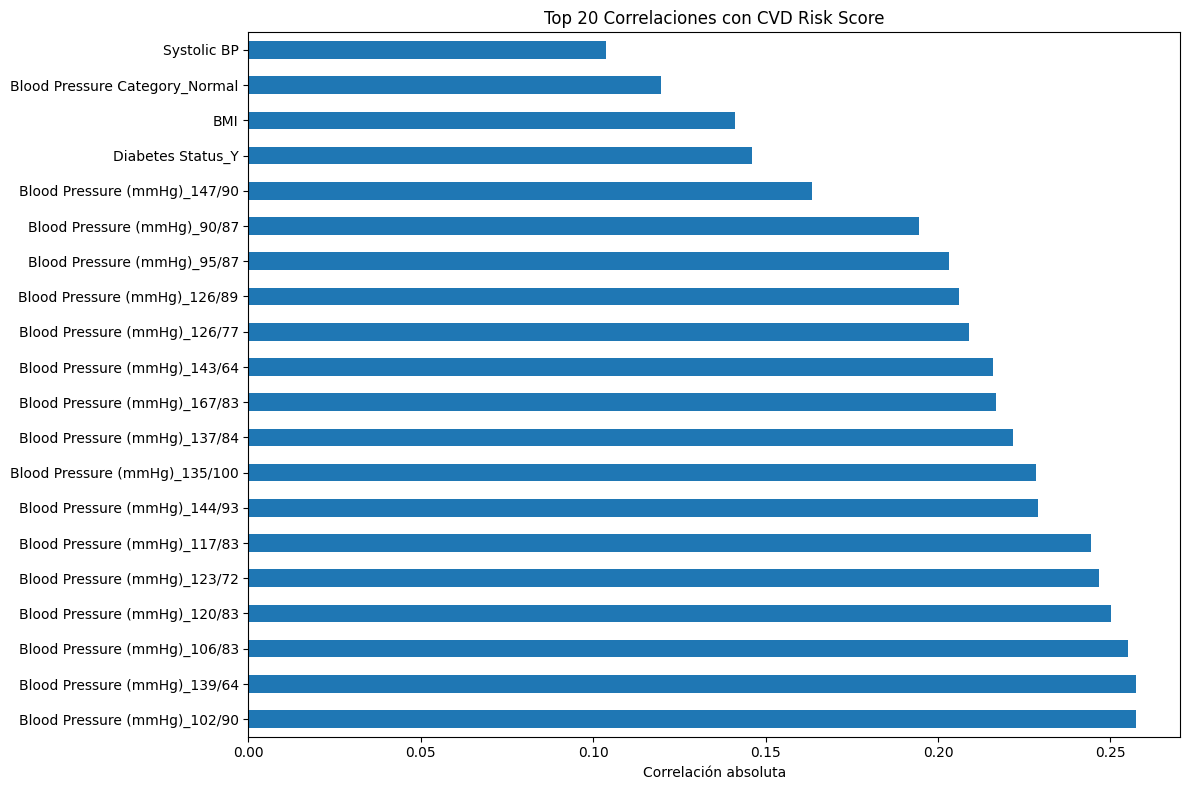


🔧 Creando features derivadas...

🎯 Top 20 con features derivadas:
Blood Pressure (mmHg)_102/90      0.257296
Blood Pressure (mmHg)_139/64      0.257264
Blood Pressure (mmHg)_106/83      0.255072
Blood Pressure (mmHg)_120/83      0.250289
Blood Pressure (mmHg)_123/72      0.246741
Blood Pressure (mmHg)_117/83      0.244312
Blood Pressure (mmHg)_144/93      0.228838
Blood Pressure (mmHg)_135/100     0.228349
Blood Pressure (mmHg)_137/84      0.221804
Blood Pressure (mmHg)_167/83      0.216891
Blood Pressure (mmHg)_143/64      0.215817
Blood Pressure (mmHg)_126/77      0.209004
Blood Pressure (mmHg)_126/89      0.206020
Blood Pressure (mmHg)_95/87       0.203216
Blood Pressure (mmHg)_90/87       0.194407
Blood Pressure (mmHg)_147/90      0.163536
Diabetes Status_Y                 0.145897
BMI                               0.141124
Blood Pressure Category_Normal    0.119731
Systolic BP                       0.103739
Name: CVD Risk Score, dtype: float64

✅ Usando 30 features

SPLIT DE DATO

In [41]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

target = "CVD Risk Score"
cols_to_remove = ["CVD Risk Score", "CVD Risk Level", "Patient ID", "Date of Service"]

# Identificar columnas
numeric_cols = [
    c for c in df_train.columns 
    if c not in cols_to_remove and pd.api.types.is_numeric_dtype(df_train[c])
]

categorical_cols = [
    c for c in df_train.columns 
    if c not in cols_to_remove and not pd.api.types.is_numeric_dtype(df_train[c])
]

print("="*60)
print("USANDO TODAS LAS OBSERVACIONES (SIN GROUPBY)")
print("="*60)
print(f"\n📊 Numéricas: {len(numeric_cols)}")
print(f"🏷️  Categóricas: {len(categorical_cols)}")

# Limpiar solo filas sin target
df_clean = df_train.dropna(subset=[target]).copy()

print(f"\n✅ Filas totales: {len(df_clean)}")
print(f"   (antes eliminabas filas al hacer groupby)")

# One-Hot Encoding
df_encoded = pd.get_dummies(
    df_clean, 
    columns=categorical_cols,
    drop_first=True,
    dummy_na=False  # Cambiado a False para que no cree columnas extra de NaN
)

print(f"✅ Shape después de encoding: {df_encoded.shape}")

# Features
feature_cols = [
    c for c in df_encoded.columns 
    if c not in ["CVD Risk Score", "CVD Risk Level", "Patient ID", "Date of Service"]
]

# Manejar NaN con imputación (mejor que dropna)
from sklearn.impute import SimpleImputer

# Separar X e y
X = df_encoded[feature_cols]
y = df_encoded[target]

# Imputar valores faltantes
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=feature_cols, index=X.index)

print(f"\n✅ Datos finales: {X_imputed_df.shape}")
print(f"   Sin perder filas por NaN!")

# ===== CORRELACIONES =====
print("\n" + "="*60)
print("CORRELACIONES")
print("="*60)

# Añadir target temporalmente para correlación
X_with_target = X_imputed_df.copy()
X_with_target[target] = y

correlations = X_with_target.corr()[target].drop(target).abs().sort_values(ascending=False)

print(f"\n📊 Top 20 correlaciones:")
print(correlations.head(20))

# Visualizar
plt.figure(figsize=(12, 8))
correlations.head(20).plot(kind='barh')
plt.title('Top 20 Correlaciones con CVD Risk Score')
plt.xlabel('Correlación absoluta')
plt.tight_layout()
plt.show()

# ===== FEATURES DERIVADAS =====
print("\n🔧 Creando features derivadas...")

X_enhanced = X_imputed_df.copy()

if 'BMI' in X_enhanced.columns and 'Age' in X_enhanced.columns:
    X_enhanced['BMI_Age'] = X_imputed_df['BMI'] * X_imputed_df['Age']
    
if 'Systolic BP' in X_enhanced.columns and 'Diastolic BP' in X_enhanced.columns:
    X_enhanced['BP_diff'] = X_imputed_df['Systolic BP'] - X_imputed_df['Diastolic BP']
    X_enhanced['BP_ratio'] = X_imputed_df['Systolic BP'] / (X_imputed_df['Diastolic BP'] + 1)
    X_enhanced['MAP'] = X_imputed_df['Diastolic BP'] + (X_enhanced['BP_diff'] / 3)
    
if 'Total Cholesterol (mg/dL)' in X_enhanced.columns and 'HDL (mg/dL)' in X_enhanced.columns:
    X_enhanced['Chol_HDL_ratio'] = X_imputed_df['Total Cholesterol (mg/dL)'] / (X_imputed_df['HDL (mg/dL)'] + 1)

# Recalcular correlaciones
X_enh_with_target = X_enhanced.copy()
X_enh_with_target[target] = y
correlations_enh = X_enh_with_target.corr()[target].drop(target).abs().sort_values(ascending=False)

print(f"\n🎯 Top 20 con features derivadas:")
print(correlations_enh.head(20))

# Seleccionar top features
top_n = min(30, len(correlations_enh))
top_features = correlations_enh.head(top_n).index.tolist()

print(f"\n✅ Usando {len(top_features)} features")

# ===== NORMALIZAR =====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enhanced[top_features])
X_scaled_df = pd.DataFrame(X_scaled, columns=top_features, index=X_enhanced.index)

# ===== TRAIN/TEST SPLIT =====
# IMPORTANTE: estratificar por Patient ID para evitar data leakage
print("\n" + "="*60)
print("SPLIT DE DATOS")
print("="*60)

# Opción segura: split aleatorio simple
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

# ===== MODELOS =====
print("\n" + "="*60)
print("ENTRENAMIENTO DE MODELOS")
print("="*60)

models = {
    'Linear Regression': linear_model.LinearRegression(),
    'Ridge': linear_model.Ridge(alpha=1.0),
    'Lasso': linear_model.Lasso(alpha=0.1, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n⏳ {name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Scores
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # CV en train
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
    
    results[name] = {
        'train_r2': train_score,
        'test_r2': test_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'model': model
    }
    
    print(f"   Train R²: {train_score:.4f}")
    print(f"   Test R²:  {test_score:.4f}")
    print(f"   CV R²:    {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===== MEJOR MODELO =====
best_model_name = max(results, key=lambda x: results[x]['test_r2'])
best_model = results[best_model_name]['model']

print("\n" + "="*60)
print(f"🏆 MEJOR MODELO: {best_model_name}")
print(f"   Train R²: {results[best_model_name]['train_r2']:.4f}")
print(f"   Test R²:  {results[best_model_name]['test_r2']:.4f}")
print(f"   CV R²:    {results[best_model_name]['cv_mean']:.4f}")
print("="*60)

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    print("\n📈 Top 15 Features Importantes:")
    importance_df = pd.DataFrame({
        'feature': top_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(importance_df.head(15))
    
    plt.figure(figsize=(12, 8))
    importance_df.head(20).plot(x='feature', y='importance', kind='barh')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

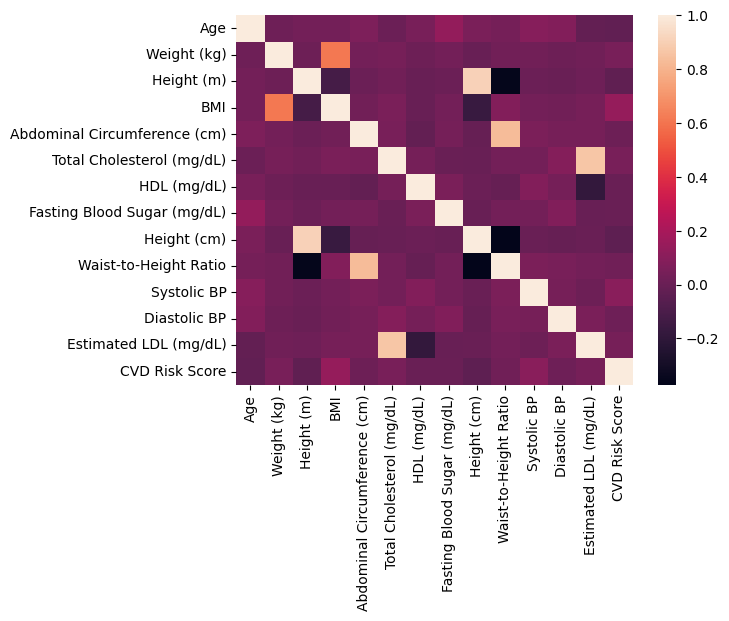

In [34]:
#Elminación de variables categóricas
sns.heatmap(df_train.corr(numeric_only=True))


cat = ['Patient ID', 'Date of Service']

VALIDACIÓN COMPLETA DEL MODELO

📊 BASELINE - ¿Qué pasa si SIEMPRE predigo la media?

   Predicción: Siempre 18.16
   MAE:  3.6760
   RMSE: 10.9689
   R²:   0.0000 (siempre será 0.0)

MODELOS CON VALIDACIÓN CRUZADA (5-FOLD)

⏳ Evaluando Linear Regression...
   CV R²:    -0.0322 ± 0.1882
   CV MAE:   2.6300 ± 0.8236
   CV RMSE:  10.5009 ± 3.5620
   Train R²: 0.9362

⏳ Evaluando Ridge...
   CV R²:    -0.0319 ± 0.1876
   CV MAE:   2.6300 ± 0.8233
   CV RMSE:  10.4997 ± 3.5619
   Train R²: 0.9362

⏳ Evaluando Random Forest...
   CV R²:    0.0173 ± 0.0844
   CV MAE:   2.7407 ± 0.7836
   CV RMSE:  10.3155 ± 3.5982
   Train R²: 0.8163

⏳ Evaluando Gradient Boosting...
   CV R²:    -0.0023 ± 0.1333
   CV MAE:   2.6528 ± 0.7827
   CV RMSE:  10.3836 ± 3.5579
   Train R²: 0.9641

COMPARACIÓN: ¿CUÁNTO MEJORA VS BASELINE?

🏆 Mejor modelo: Random Forest

   BASELINE (predecir media):
      MAE:  3.6760
      RMSE: 10.9689

   Random Forest:
      MAE:  2.7407
      RMSE: 10.3155

   📈 MEJORA:
      M

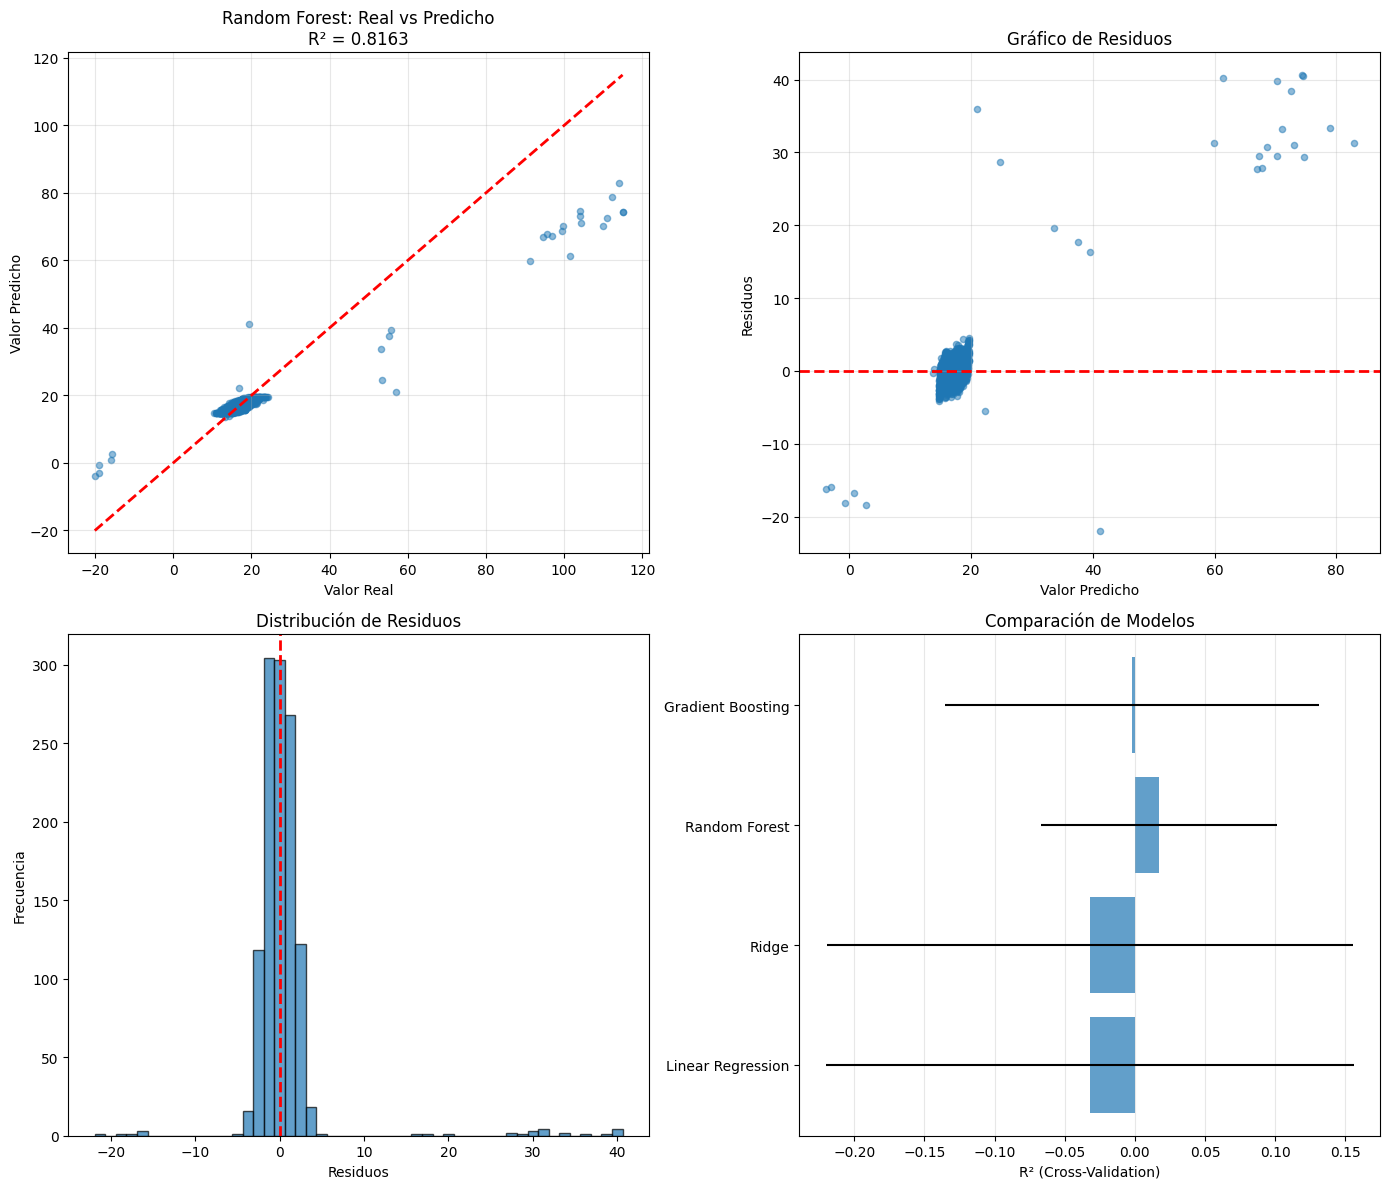


📈 Top 15 Features más importantes:
                          feature  importance
2    Blood Pressure (mmHg)_106/83    0.070730
3    Blood Pressure (mmHg)_120/83    0.069025
0    Blood Pressure (mmHg)_102/90    0.067798
1    Blood Pressure (mmHg)_139/64    0.065427
4    Blood Pressure (mmHg)_123/72    0.061679
6    Blood Pressure (mmHg)_144/93    0.058258
7   Blood Pressure (mmHg)_135/100    0.057886
5    Blood Pressure (mmHg)_117/83    0.055612
12   Blood Pressure (mmHg)_126/89    0.052792
27                        BMI_Age    0.052460
10   Blood Pressure (mmHg)_143/64    0.050697
9    Blood Pressure (mmHg)_167/83    0.046683
13    Blood Pressure (mmHg)_95/87    0.046333
11   Blood Pressure (mmHg)_126/77    0.046043
15   Blood Pressure (mmHg)_147/90    0.045894

🎯 RESUMEN FINAL

✅ Mejor modelo: Random Forest
✅ R² (CV):      0.0173 ± 0.0844
✅ MAE (CV):     2.7407
✅ RMSE (CV):    10.3155

💡 El modelo reduce el error promedio en 25.4% vs predecir siempre la media

❌ CONCLUSIÓN: El modelo 

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ===== PREPARACIÓN DE DATOS (SIN GROUPBY) =====
target = "CVD Risk Score"
cols_to_remove = ["CVD Risk Score", "CVD Risk Level", "Patient ID", "Date of Service"]

numeric_cols = [
    c for c in df_train.columns 
    if c not in cols_to_remove and pd.api.types.is_numeric_dtype(df_train[c])
]

categorical_cols = [
    c for c in df_train.columns 
    if c not in cols_to_remove and not pd.api.types.is_numeric_dtype(df_train[c])
]

# Sin groupby - todas las observaciones
df_clean = df_train.dropna(subset=[target]).copy()

# One-Hot Encoding
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True, dummy_na=False)

feature_cols = [
    c for c in df_encoded.columns 
    if c not in ["CVD Risk Score", "CVD Risk Level", "Patient ID", "Date of Service"]
]

X = df_encoded[feature_cols]
y = df_encoded[target]

# Imputar
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X_imputed_df = pd.DataFrame(X_imputed, columns=feature_cols, index=X.index)

# Features derivadas
X_enhanced = X_imputed_df.copy()

if 'BMI' in X_enhanced.columns and 'Age' in X_enhanced.columns:
    X_enhanced['BMI_Age'] = X_imputed_df['BMI'] * X_imputed_df['Age']
    
if 'Systolic BP' in X_enhanced.columns and 'Diastolic BP' in X_enhanced.columns:
    X_enhanced['BP_diff'] = X_imputed_df['Systolic BP'] - X_imputed_df['Diastolic BP']
    X_enhanced['BP_ratio'] = X_imputed_df['Systolic BP'] / (X_imputed_df['Diastolic BP'] + 1)
    
if 'Total Cholesterol (mg/dL)' in X_enhanced.columns and 'HDL (mg/dL)' in X_enhanced.columns:
    X_enhanced['Chol_HDL_ratio'] = X_imputed_df['Total Cholesterol (mg/dL)'] / (X_imputed_df['HDL (mg/dL)'] + 1)

# Top features por correlación
X_with_target = X_enhanced.copy()
X_with_target[target] = y
correlations = X_with_target.corr()[target].drop(target).abs().sort_values(ascending=False)
top_features = correlations.head(30).index.tolist()

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enhanced[top_features])
X_scaled_df = pd.DataFrame(X_scaled, columns=top_features, index=X_enhanced.index)

print("="*70)
print("VALIDACIÓN COMPLETA DEL MODELO")
print("="*70)

# ===== 1. BASELINE: Modelo Dummy (predice siempre la media) =====
print("\n📊 BASELINE - ¿Qué pasa si SIEMPRE predigo la media?")
y_mean = y.mean()
y_baseline = np.full(len(y), y_mean)

baseline_mae = mean_absolute_error(y, y_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y, y_baseline))
baseline_r2 = r2_score(y, y_baseline)

print(f"\n   Predicción: Siempre {y_mean:.2f}")
print(f"   MAE:  {baseline_mae:.4f}")
print(f"   RMSE: {baseline_rmse:.4f}")
print(f"   R²:   {baseline_r2:.4f} (siempre será 0.0)")

# ===== 2. MODELOS CON VALIDACIÓN CRUZADA =====
print("\n" + "="*70)
print("MODELOS CON VALIDACIÓN CRUZADA (5-FOLD)")
print("="*70)

models = {
    'Linear Regression': linear_model.LinearRegression(),
    'Ridge': linear_model.Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n⏳ Evaluando {name}...")
    
    # Cross-validation con múltiples métricas
    cv_r2 = cross_val_score(model, X_scaled_df, y, cv=5, scoring='r2', n_jobs=-1)
    cv_mae = -cross_val_score(model, X_scaled_df, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_rmse = np.sqrt(-cross_val_score(model, X_scaled_df, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1))
    
    # Fit completo para comparar
    model.fit(X_scaled_df, y)
    y_pred = model.predict(X_scaled_df)
    
    train_r2 = r2_score(y, y_pred)
    train_mae = mean_absolute_error(y, y_pred)
    train_rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    results[name] = {
        'cv_r2_mean': cv_r2.mean(),
        'cv_r2_std': cv_r2.std(),
        'cv_mae_mean': cv_mae.mean(),
        'cv_rmse_mean': cv_rmse.mean(),
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_rmse': train_rmse,
        'model': model,
        'predictions': y_pred
    }
    
    print(f"   CV R²:    {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
    print(f"   CV MAE:   {cv_mae.mean():.4f} ± {cv_mae.std():.4f}")
    print(f"   CV RMSE:  {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
    print(f"   Train R²: {train_r2:.4f}")

# ===== 3. COMPARACIÓN CON BASELINE =====
print("\n" + "="*70)
print("COMPARACIÓN: ¿CUÁNTO MEJORA VS BASELINE?")
print("="*70)

best_model_name = max(results, key=lambda x: results[x]['cv_r2_mean'])
best_result = results[best_model_name]

print(f"\n🏆 Mejor modelo: {best_model_name}")
print(f"\n   BASELINE (predecir media):")
print(f"      MAE:  {baseline_mae:.4f}")
print(f"      RMSE: {baseline_rmse:.4f}")
print(f"\n   {best_model_name}:")
print(f"      MAE:  {best_result['cv_mae_mean']:.4f}")
print(f"      RMSE: {best_result['cv_rmse_mean']:.4f}")
print(f"\n   📈 MEJORA:")
print(f"      MAE:  {((baseline_mae - best_result['cv_mae_mean']) / baseline_mae * 100):.1f}% mejor")
print(f"      RMSE: {((baseline_rmse - best_result['cv_rmse_mean']) / baseline_rmse * 100):.1f}% mejor")

# ===== 4. INTERPRETACIÓN DEL R² =====
print("\n" + "="*70)
print("INTERPRETACIÓN DEL R²")
print("="*70)

cv_r2 = best_result['cv_r2_mean']

print(f"\n   R² = {cv_r2:.4f}")
print(f"\n   Esto significa que el modelo explica el {cv_r2*100:.1f}% de la varianza del target.")

if cv_r2 < 0.3:
    print("   ❌ MALO: El modelo apenas explica la variabilidad. Casi tan malo como predecir la media.")
elif cv_r2 < 0.5:
    print("   ⚠️  REGULAR: Hay algo de poder predictivo, pero es limitado.")
elif cv_r2 < 0.7:
    print("   ✅ BUENO: Poder predictivo decente para muchos problemas del mundo real.")
elif cv_r2 < 0.9:
    print("   🌟 MUY BUENO: Excelente poder predictivo.")
else:
    print("   🎯 EXCELENTE: Poder predictivo excepcional (¡cuidado con overfitting!)")

# ===== 5. ERROR EN TÉRMINOS REALES =====
print("\n" + "="*70)
print("ERROR EN UNIDADES REALES (CVD Risk Score)")
print("="*70)

print(f"\n   Rango del target: [{y.min():.2f}, {y.max():.2f}]")
print(f"   Media: {y.mean():.2f}")
print(f"   Desviación estándar: {y.std():.2f}")
print(f"\n   Error promedio del modelo (MAE): {best_result['cv_mae_mean']:.2f}")
print(f"   Error como % de la desviación estándar: {(best_result['cv_mae_mean'] / y.std() * 100):.1f}%")

# ===== 6. VISUALIZACIÓN DE PREDICCIONES =====
print("\n📊 Generando gráficos de evaluación...")

best_model = best_result['model']
y_pred = best_result['predictions']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Real vs Predicho
axes[0, 0].scatter(y, y_pred, alpha=0.5, s=20)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valor Real')
axes[0, 0].set_ylabel('Valor Predicho')
axes[0, 0].set_title(f'{best_model_name}: Real vs Predicho\nR² = {best_result["train_r2"]:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuos
residuals = y - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Valor Predicho')
axes[0, 1].set_ylabel('Residuos')
axes[0, 1].set_title('Gráfico de Residuos')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distribución de residuos
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuos')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Residuos')

# Plot 4: Comparación de modelos
model_names = list(results.keys())
cv_r2_scores = [results[m]['cv_r2_mean'] for m in model_names]
cv_r2_stds = [results[m]['cv_r2_std'] for m in model_names]

axes[1, 1].barh(model_names, cv_r2_scores, xerr=cv_r2_stds, alpha=0.7)
axes[1, 1].set_xlabel('R² (Cross-Validation)')
axes[1, 1].set_title('Comparación de Modelos')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ===== 7. FEATURE IMPORTANCE =====
if hasattr(best_model, 'feature_importances_'):
    print("\n📈 Top 15 Features más importantes:")
    importance_df = pd.DataFrame({
        'feature': top_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(importance_df.head(15))

# ===== RESUMEN FINAL =====
print("\n" + "="*70)
print("🎯 RESUMEN FINAL")
print("="*70)
print(f"\n✅ Mejor modelo: {best_model_name}")
print(f"✅ R² (CV):      {best_result['cv_r2_mean']:.4f} ± {best_result['cv_r2_std']:.4f}")
print(f"✅ MAE (CV):     {best_result['cv_mae_mean']:.4f}")
print(f"✅ RMSE (CV):    {best_result['cv_rmse_mean']:.4f}")
print(f"\n💡 El modelo reduce el error promedio en {((baseline_mae - best_result['cv_mae_mean']) / baseline_mae * 100):.1f}% vs predecir siempre la media")

if cv_r2 < 0.3:
    print("\n❌ CONCLUSIÓN: El modelo NO es bueno. Busca más features o revisa la calidad de los datos.")
elif cv_r2 < 0.5:
    print("\n⚠️  CONCLUSIÓN: El modelo es REGULAR. Puede servir pero hay margen de mejora.")
else:
    print("\n✅ CONCLUSIÓN: El modelo es ÚTIL y tiene poder predictivo significativo.")

print("="*70)

📊 Columnas numéricas encontradas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
🏷️  Columnas categóricas encontradas: ['Sex', 'Blood Pressure (mmHg)', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category', 0]
✅ Filas en df_train original: 4703
✅ Filas después de quitar NaN en target: 1178
✅ Columnas ANTES del encoding: 25
✅ Columnas DESPUÉS del encoding: 1044
   Se crearon 1019 columnas nuevas
✅ X (features): (1178, 1040)
✅ y (target): (1178,)
✅ Valores NaN eliminados mediante imputación con la mediana
✅ Creada feature: BMI_Age
✅ Creadas features: BP_diff, BP_ratio
✅ Creada feature: Chol_HDL_ratio
✅ Features totales ahora: 1044

📊 Top 10 features más correlacionadas:
Blood Pressure (mmHg)_102/90     0.257296
Blood Pressure (mmHg

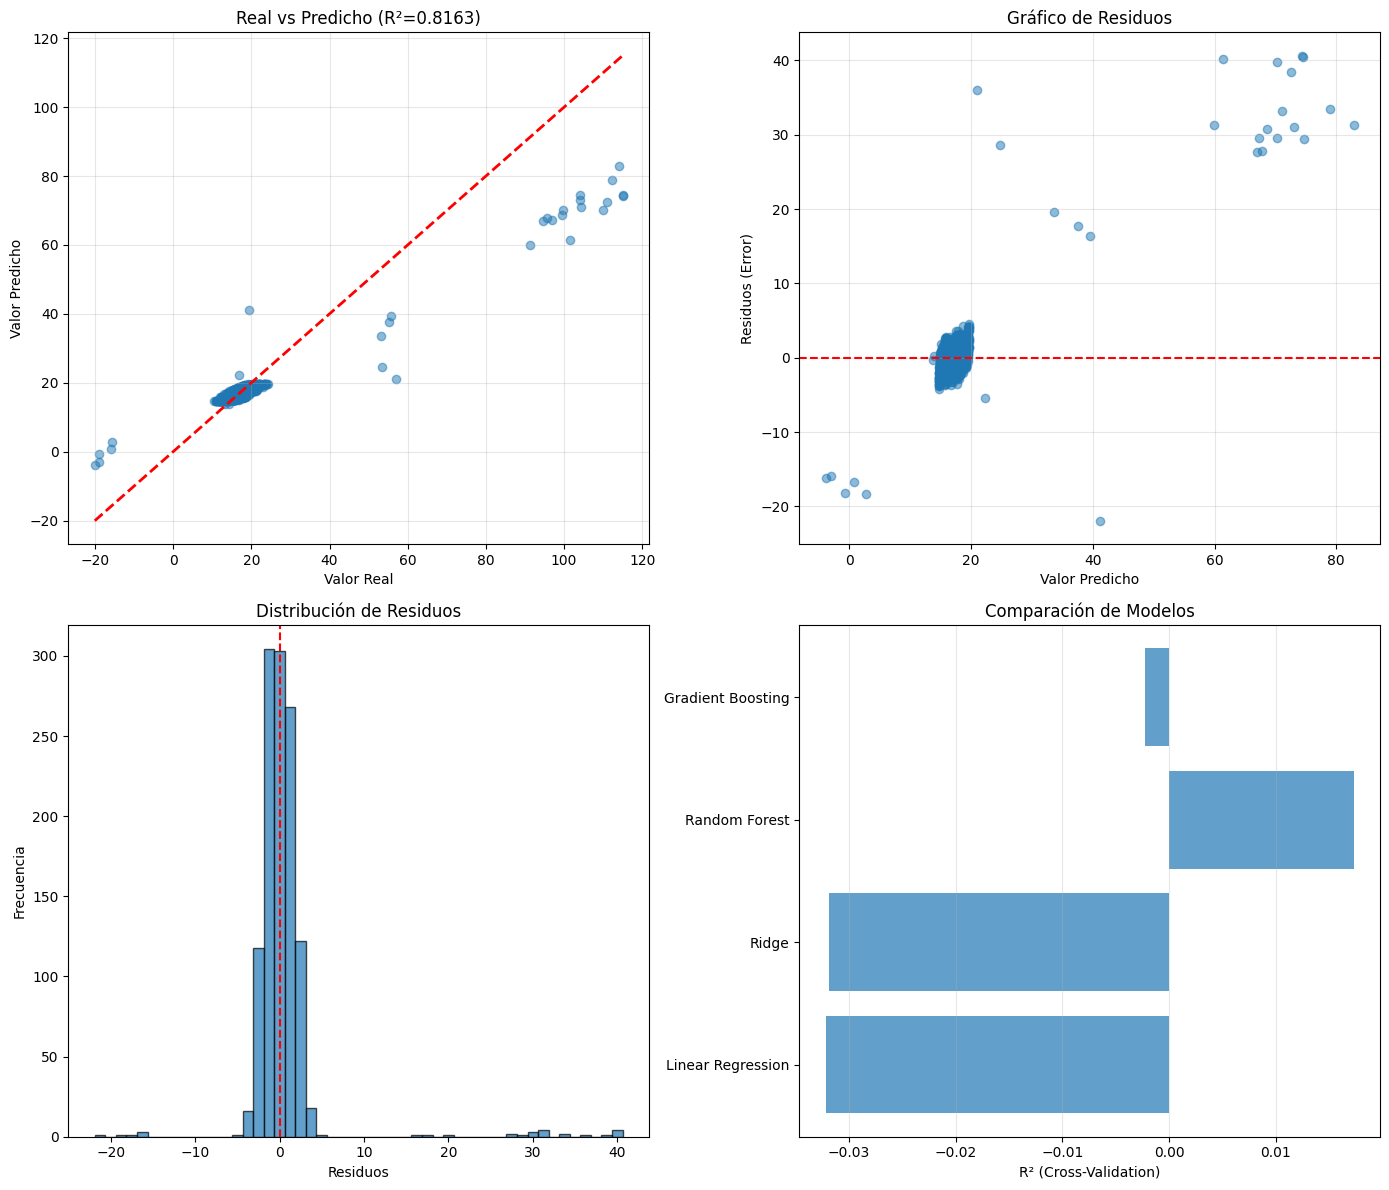


✅ Código completado exitosamente!
